In [1]:
import surprise
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import os

In [5]:
raw=pd.read_csv('data/ml-1m/ratings.dat', names=['userID', 'movieID', 'rating', 'time'], delimiter='|')
raw.drop_duplicates(inplace=True)
print('we have',raw.shape[0], 'ratings')
print('the number of unique users we have is:', len(raw.userID.unique()))
print('the number of unique movies we have is:', len(raw.movieID.unique()))
print("The median user rated %d movies."%raw.userID.value_counts().median())
print('The max rating is: %d'%raw.rating.max(),"the min rating is: %d"%raw.rating.min())
raw.head()

we have 1000209 ratings
the number of unique users we have is: 6040
the number of unique movies we have is: 3706
The median user rated 96 movies.
The max rating is: 5 the min rating is: 1


,userID,movieID,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
raw=raw[['userID','movieID','rating']] 
raw.columns = ['n_users','n_items','rating']

rawTrain,rawholdout = train_test_split(raw, test_size=0.25 )
# when importing from a DF, you only need to specify the scale of the ratings.
reader = surprise.Reader(rating_scale=(1,5)) 
#into surprise:
data = surprise.Dataset.load_from_df(rawTrain,reader)
holdout = surprise.Dataset.load_from_df(rawholdout,reader)

## Separação em 10 folds

In [7]:
kSplit = surprise.model_selection.split.KFold(n_splits=10, shuffle=True)

## Análise do KNN

In [8]:
sim_options = sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between items
               }
collabKNN = surprise.KNNWithMeans(k=40,sim_options=sim_options) #try removing sim_options. You'll find memory errors. 
rmseKNN = []
rmseSVD = []
rmseCo = []
rmseSlope = []
for trainset, testset in kSplit.split(data): #iterate through the folds.
    collabKNN.fit(trainset)
    predictionsKNN = collabKNN.test(testset)
    rmseKNN.append(surprise.accuracy.rmse(predictionsKNN,verbose=True))#get root means squared error

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9433
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9407
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9452
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9384
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9438
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9388
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9418
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9404
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9452
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9429


In [19]:
print(rmseKNN)

[0.9432982719919455, 0.9406858176344778, 0.9452327869727271, 0.938404968110122, 0.9438227776446855, 0.9387873805192561, 0.9417949804570742, 0.9403976040119383, 0.9451669788032169, 0.9429358169104897]


## Analise do SVD

In [9]:
funkSVD = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

In [10]:
min_error = 1
for trainset, testset in kSplit.split(data): #iterate through the folds.
    funkSVD.fit(trainset)
    predictionsSVD = funkSVD.test(testset)
    rmseSVD.append(surprise.accuracy.rmse(predictionsSVD,verbose=True))#get root means squared error

RMSE: 0.9052
RMSE: 0.9048
RMSE: 0.9084
RMSE: 0.9035
RMSE: 0.9083
RMSE: 0.9061
RMSE: 0.9009
RMSE: 0.9025
RMSE: 0.9055
RMSE: 0.9036


In [18]:
print(rmseSVD)

[0.9051537612968179, 0.9048211279543357, 0.9083606507263591, 0.9034619923208048, 0.9082586047239551, 0.9061427116333111, 0.9009310201769661, 0.9025084409995953, 0.9055407714679061, 0.9036419457947882]


## Análise do Slope One

In [11]:
slopeOne = surprise.prediction_algorithms.slope_one.SlopeOne()

In [12]:
for trainset, testset in kSplit.split(data): #iterate through the folds.
    slopeOne.fit(trainset)
    predictionsSlope = slopeOne.test(testset)
    rmseSlope.append(surprise.accuracy.rmse(predictionsSlope,verbose=True))#get root means squared error

RMSE: 0.9022
RMSE: 0.9087
RMSE: 0.9090
RMSE: 0.9072
RMSE: 0.9090
RMSE: 0.9062
RMSE: 0.9100
RMSE: 0.9156
RMSE: 0.9064
RMSE: 0.9062


In [17]:
print(rmseSlope)

[0.902166891293989, 0.9086660158477209, 0.9089529241015687, 0.9072394447603462, 0.908961070274807, 0.9062368556692045, 0.9100374401671667, 0.9156200612833867, 0.9064493976228852, 0.9062349382845631]


## Gráfico dos algoritmos

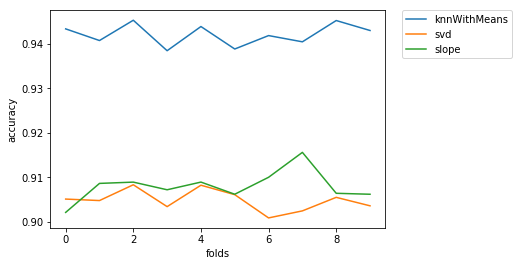

In [21]:
#plotting the prediction data:
import matplotlib.pyplot as plt
#for prediction in compiledPredictions:
modelPrediction = plt.plot(rmseKNN,label='knnWithMeans')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseSlope,label='slope')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Tornando os dados hybridos

In [34]:
class HybridFacto(surprise.AlgoBase):
    def __init__(self,epochs, learning_rate,num_models):
        self.alpha = np.array([1/num_models]*num_models)
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit(self,holdout):
        holdout=holdout.build_full_trainset().build_testset()
        for epoch in range(self.epochs):
            
            predictions = np.array([collabKNN.test(holdout),funkSVD.test(holdout),slopeOne.test(holdout)])
            maeGradient = [surprise.accuracy.mae(prediction) for prediction in predictions]
            newalpha = self.alpha - learning_rate * maeGradient  
            #convergence check:
            if newalpha - self.alpha < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,u,i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        algoResults = np.array([collabKNN.predict(u,i),funkSVD.predict(u,i),slopeOne.predict(u,i)])
        return np.sum(np.dot(self.alpha,algoResults))

In [35]:
hybrid = HybridFacto(10, 0.05, 3)
hybrid.fit(holdout)
rmseHyb = []
for trainset, testset in kSplit.split(data): #iterate through the folds.
    predhybrid = Hyhybrid.test(testset)
    rmseHyb.append(surprise.accuracy.rmse(predhybrid))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'rmseHyb' is not defined

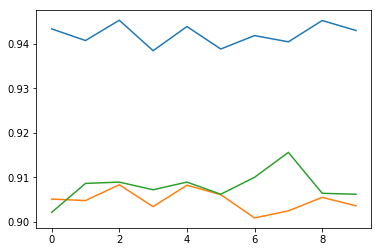

In [36]:
#plotting the prediction data:
#for prediction in compiledPredictions:
modelPrediction = plt.plot(rmseKNN,label='knnWithMeans')
modelPrediction = plt.plot(rmseSVD,label='svd')
modelPrediction = plt.plot(rmseSlope,label='slope')
modelPrediction = plt.plot(rmseHyb,label='Hybrid')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)